**Problem 1:**

In [1]:
!pip install wandb

wandb: Currently logged in as: ma22c019 (believer12). Use `wandb login --relogin` to force relogin


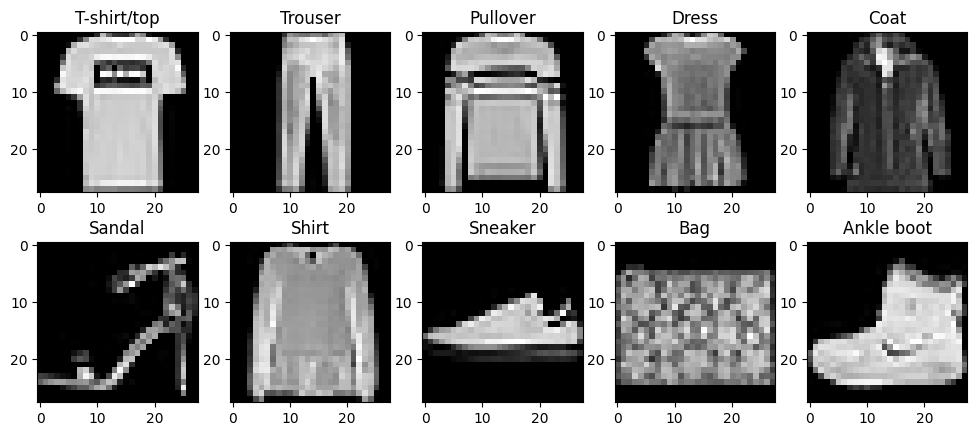

In [2]:
# Importing packages
import wandb
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Initialize WandB project
wandb.init(project="set-1")

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define class names for Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plotting a figure from each class
plt.figure(figsize=[12, 5])
images = []
captions = []

# Loop through each class
for i, class_name in enumerate(class_names):
    # Find the first image of the current class
    index = np.argmax(y_train == i)
    image = x_train[index]

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(class_name)

    # Append the image and its caption to lists
    images.append(image)
    captions.append(class_name)

# Log images to WandB
wandb.log({"Fashion MNIST Images": [wandb.Image(img, caption=caption) for img, caption in zip(images, captions)]})

plt.show()  # Show the plot


**Problem 2:**

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Flatten images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Split data into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(x_train, y_train_encoded, test_size=0.1, random_state=42)

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, num_neurons, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.num_neurons = num_neurons
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.activations = [self.relu] * (self.hidden_layers) + [self.softmax]

        # Initialize weights and biases for hidden layers
        for i in range(self.hidden_layers):
            if i == 0:
                self.weights.append(np.random.randn(self.input_size, self.num_neurons))
            else:
                self.weights.append(np.random.randn(self.num_neurons, self.num_neurons))
            self.biases.append(np.zeros((1, self.num_neurons)))

        # Initialize weights and biases for output layer
        self.weights.append(np.random.randn(self.num_neurons, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def forward(self, x):
        output = x
        for i in range(self.hidden_layers + 1):
            output = np.dot(output, self.weights[i]) + self.biases[i]
            output = self.activations[i](output)
        return output

    def backward(self, x, y, lr):
        # Forward pass
        layer_outputs = [x]
        for i in range(self.hidden_layers + 1):
            layer_outputs.append(np.dot(layer_outputs[i], self.weights[i]) + self.biases[i])
            layer_outputs[i+1] = self.activations[i](layer_outputs[i+1])

        # Backward pass
        errors = [None] * (self.hidden_layers + 1)
        errors[-1] = layer_outputs[-1] - y
        for i in range(self.hidden_layers, 0, -1):
            errors[i-1] = np.dot(errors[i], self.weights[i].T) * (layer_outputs[i] > 0)

        # Update weights and biases
        for i in range(self.hidden_layers + 1):
            self.weights[i] -= lr * np.dot(layer_outputs[i].T, errors[i])
            self.biases[i] -= lr * np.sum(errors[i], axis=0)

    def train(self, x_train, y_train, x_val, y_val, lr, epochs, batch_size):
        num_batches = len(x_train) // batch_size
        for epoch in range(1, epochs+1):
            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size
                x_batch = x_train[start:end]
                y_batch = y_train[start:end]
                self.backward(x_batch, y_batch, lr)

            # Evaluate on validation set
            val_pred = self.predict(x_val)
            val_loss = self.cross_entropy_loss(val_pred, y_val)
            val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
            print(f"Epoch {epoch}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    def predict(self, x):
        return self.forward(x)

    def cross_entropy_loss(self, y_pred, y_true):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# Model parameters
input_size = x_train.shape[1]
hidden_layers = 2
num_neurons = 256
output_size = 10
lr = 0.001
epochs = 10
batch_size = 64

# Create and train the model
model = NeuralNetwork(input_size, hidden_layers, num_neurons, output_size)
model.train(x_train, y_train_encoded, x_val, y_val_encoded, lr, epochs, batch_size)

# Evaluate on test set
test_pred = model.predict(x_test)
test_acc = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(test_pred, axis=1))
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 2/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 3/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 4/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 5/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 6/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 7/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 8/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 9/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Epoch 10/10, Validation Loss: 2.3025, Validation Accuracy: 0.1035
Test Accuracy: 0.0997


**Problem 3:**

**Activation Functions and their Derivatives**

In [4]:
import numpy as np

class Sigmoid():
    def __init__(self, c=1, b=0):
        self.c = c
        self.b = b

    def value(self, x):
        val = 1 + np.exp(-self.c*(x + self.b))
        return 1/val

    def diff(self, x, remove=False):
        y = self.value(x)
        if remove==True:
            y = y[:-1,:]
        val = self.c*y*(1-y)
        return val

class Tanh():
    def __init__(self):
        pass

    def value(self, x):
        num = np.exp(x) - np.exp(-x)
        denom = np.exp(x) + np.exp(-x)
        return num/denom

    def diff(self, x):
        y = self.value(x)
        val = 1 - y**2
        return val

class Relu():
    def __init__(self):
        pass

    def value(self, x):
        val = x
        val[val<0] = 0
        return val

    def diff(self, x):
        val = np.ones(x.shape)
        val[val<=0] = 0
        return val

class Softmax():
    def __init__(self):
        pass

    def value(self, x):
        # Numerically stable softmax
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def diff(self, x):
        # Compute the softmax function
        softmax_output = self.value(x)
        # Compute the Jacobian matrix of the softmax function
        n = softmax_output.shape[1]
        jacobian_matrix = np.zeros((n, n, n))
        for i in range(n):
            for j in range(n):
                if i == j:
                    jacobian_matrix[i, j, :] = softmax_output[:, i] * (1 - softmax_output[:, j])
                else:
                    jacobian_matrix[i, j, :] = -softmax_output[:, i] * softmax_output[:, j]
        return jacobian_matrix.sum(axis=1)

map_activations = {"Sigmoid":Sigmoid(), "Tanh":Tanh(), "Relu":Relu(), "Softmax":Softmax()}

**Layers**

In [5]:
import numpy as np

class Layer():
    def __init__(self, name, size, activation=None):
        self.name = name
        self.size = size
        self.activation = activation
        self.type = self.__class__.__name__

    def __repr__(self):
        activation_info = f"; Activation: {self.activation}" if self.activation else ""
        return f"{self.type} - of Size: {self.size}" + activation_info


class Input(Layer):
    def __init__(self, data, name=None, size=None):
        super().__init__(name, size)
        self.data = data
        self.a = self.data
        self.a_val = None

class Dense(Layer):
    def __init__(self, size, activation=None, name=None):
        name = name if name else f"Dense_{np.random.randint(1e6)}"
        super().__init__(name, size, activation)

**Optimizers**

In [6]:
import numpy as np

class Optimizer():
    def __init__(self, **kwargs):
        self.params = kwargs
        self.initialize_params()

    def initialize_params(self):
        pass


    def update(self, grad):
        pass

class Normal(Optimizer):
    def __init__(self, eta):
        self.eta = eta

    def update(self, grad):
        return self.eta * grad

class Momentum(Optimizer):
    def initialize_params(self):
        self.v = 0

    def update(self, grad):
        self.v = self.params['gamma'] * self.v + self.params['eta'] * grad
        return self.v

class Nesterov(Optimizer):
    def initialize_params(self):
        self.v = 0

    def update(self, grad):
        self.v = self.params['gamma'] * self.v + self.params['eta'] * grad
        return self.params['gamma'] * self.v + self.params['eta'] * grad

class AdaGrad(Optimizer):
    def initialize_params(self):
        self.v = 0

    def update(self, grad):
        self.v += grad ** 2
        return (self.params['eta'] / (self.v + self.params['eps']) ** 0.5) * grad

class RMSProp(Optimizer):
    def initialize_params(self):
        self.v = 0

    def update(self, grad):
        self.v = self.params['beta'] * self.v + (1 - self.params['beta']) * grad ** 2
        return (self.params['eta'] / (self.v + self.params['eps']) ** 0.5) * grad

class Adam(Optimizer):
    def initialize_params(self):
        self.m = 0
        self.v = 0
        self.iter = 1

    def update(self, grad):
        self.m = self.params['beta1'] * self.m + (1 - self.params['beta1']) * grad
        self.v = self.params['beta2'] * self.v + (1 - self.params['beta2']) * grad ** 2
        m_cap = self.m / (1 - self.params['beta1'] ** self.iter)
        v_cap = self.v / (1 - self.params['beta2'] ** self.iter)
        self.iter += 1
        return (self.params['eta'] / (v_cap + self.params['eps']) ** 0.5) * m_cap

class Nadam(Adam):
    def update(self, grad):
        self.m = self.params['beta1'] * self.m + (1 - self.params['beta1']) * grad
        self.v = self.params['beta2'] * self.v + (1 - self.params['beta2']) * grad ** 2
        m_cap = self.m / (1 - self.params['beta1'] ** self.iter)
        v_cap = self.v / (1 - self.params['beta2'] ** self.iter)
        update = self.params['beta1'] * m_cap + ((1 - self.params['beta1']) / (1 - self.params['beta1'] ** self.iter)) * grad
        self.iter += 1
        return (self.params['eta'] / (v_cap + self.params['eps']) ** 0.5) * update

**Loss**

In [7]:
import numpy as np

class CrossEntropy:
    def __init__(self):
        pass

    def calc_loss(self, t, y):
        self.t = t
        self.y = y
        loss = -np.sum(t * np.log(y))
        return loss

    def diff(self, t_batch, y_batch):
        grad = -t_batch / y_batch
        return grad

class SquaredError:
    def __init__(self):
        pass

    def calc_loss(self, t, y):
        self.t = t
        self.y = y
        loss = np.sum((t - y) ** 2)
        return loss

    def diff(self, t_batch, y_batch):
        grad = -(t_batch - y_batch)
        return grad


**Helper**

In [8]:
import numpy as np

class OneHotEncoder:
    def __init__(self):
        pass

    def fit(self, y, num_classes):
        self.y = y
        self.num_classes = num_classes

    def transform(self):
        transformed = np.eye(self.num_classes)[self.y].T
        return transformed

    def fit_transform(self, y, num_classes):
        self.fit(y, num_classes)
        return self.transform()

    def inverse_transform(self, y):
        y_class = np.argmax(y, axis=0)
        return y_class


class MinMaxScaler:
    def __init__(self):
        pass

    def fit(self, X):
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)

    def transform(self, X):
        transformed = (X - self.min) / (self.max - self.min)
        return transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

**Neural NetworK**

In [11]:
import math
import numpy as np
from tqdm import tqdm
from copy import deepcopy

class NeuralNetwork:
    def __init__(self, layers, batch_size, optimizer, initialization, epochs, t, loss, X_val=None, t_val=None, use_wandb=False, optim_params=None):
        self.layers = layers
        self.batch_size = batch_size
        self.initialization = initialization
        self.epochs = epochs
        self.optimizer = optimizer
        self.t = t
        self.t_val = t_val
        self.loss = loss
        self.use_wandb = use_wandb
        self.num_batches = math.ceil(t.shape[1] / batch_size)
        self.X_val = X_val
        self.param_init(optimizer, optim_params)


    def param_init(self, optimizer, optim_params):
      size_prev = self.layers[0].data.shape[1]
      for layer in self.layers[1:]:
        layer.W_size = (layer.size, size_prev)
        size_prev = layer.size
        layer.W_optimizer = deepcopy(optimizer(eta=0.01))
        layer.b_optimizer = deepcopy(optimizer(eta=0.01))
      if optim_params:
        for layer, params in zip(self.layers[1:], optim_params):
            layer.W_optimizer.eta = params[0]
            layer.b_optimizer.eta = params[1]
      if self.initialization == "RandomNormal":
        for layer in self.layers[1:]:
            layer.W = np.random.normal(loc=0, scale=1.0, size=layer.W_size)
            layer.b = np.zeros((layer.W_size[0], 1))
      elif self.initialization == "XavierUniform":
        for layer in self.layers[1:]:
            limit = np.sqrt(6 / (layer.W_size[0] + layer.W_size[1]))
            layer.W = np.random.uniform(-limit, limit, layer.W_size)
            layer.b = np.zeros((layer.W_size[0], 1))



# In the NeuralNetwork class, update the forward_propagation method
    def forward_propagation(self):
      for i in range(1, len(self.layers)):
        self.layers[i].h = self.layers[i].W @ self.layers[i-1].a - self.layers[i].b
        self.layers[i].a = self.layers[i].activation.value(self.layers[i].h)
        if self.t_val is not None:
            self.layers[i].h_val = self.layers[i].W @ self.layers[i-1].a_val - self.layers[i].b
            self.layers[i].a_val = self.layers[i].activation.value(self.layers[i].h_val)

        if self.loss_type == "CrossEntropy":
          self.layers[-1].y = Softmax().value(self.layers[-1].a).T  # Transpose y here
          if self.t_val is not None:
            self.layers[-1].y_val = Softmax().value(self.layers[-1].a_val).T
      else:
        self.layers[-1].y = self.layers[-1].a.T  # Transpose y here
        if self.t_val is not None:
            self.layers[-1].y_val = self.layers[-1].a_val.T

    def check_test(self, X_test, t_test):
        self.layers[0].a_test = X_test
        for i in range(1, len(self.layers)):
            self.layers[i].h_test = self.layers[i].W @ self.layers[i-1].a_test - self.layers[i].b
            self.layers[i].a_test = self.layers[i].activation.value(self.layers[i].h_test)

        if self.loss == "CrossEntropy":
            self.layers[-1].y_test = Softmax().value(self.layers[-1].a_test)
        else:
            self.layers[-1].y_test = self.layers[-1].a_test

        loss_test = self.loss.calc_loss(t_test, self.layers[-1].y_test)

        encoder = OneHotEncoder()
        y_tmp = encoder.inverse_transform(self.layers[-1].y_test)
        t_tmp = encoder.inverse_transform(t_test)
        acc_test = np.sum(y_tmp == t_tmp)
        return acc_test, loss_test, y_tmp

    def backward_propagation(self):
        self.eta_hist = []
        self.loss_hist = []
        self.accuracy_hist = []
        self.loss_hist_val = []
        self.accuracy_hist_val = []
        flag = 0

        for ep in tqdm(range(self.epochs)):
            self.eta_hist.append(self.layers[-1].W_optimizer.eta)
            self.loss_hist.append(self.loss.calc_loss(self.t, self.layers[-1].y))
            train_acc, val_acc = self.get_accuracy(validation=True)
            self.accuracy_hist.append(train_acc)
            self.loss_hist_val.append(self.loss.calc_loss(self.t_val, self.layers[-1].y_val))
            self.accuracy_hist_val.append(val_acc)

            if self.use_wandb:
                wandb.log({
                    "step": ep,
                    "loss:": self.loss_hist[-1] / self.t.shape[1],
                    "accuracy": self.accuracy_hist[-1] / self.t.shape[1],
                    "val_loss": self.loss_hist_val[-1] / self.t_val.shape[1],
                    "val_accuracy": self.accuracy_hist_val[-1] / self.t_val.shape[1]
                })

            for batch in range(self.num_batches):
                t_batch = self.t[:, batch * self.batch_size:(batch + 1) * self.batch_size]
                y_batch = self.layers[-1].y[:, batch * self.batch_size:(batch + 1) * self.batch_size]
                self.y_batch = y_batch
                self.t_batch = t_batch

                if flag == 1:
                    break

                if flag == 1:
                    break

    def describe(self):
        print("Model with the following layers:")
        for layer in self.layers:
            print(layer)
        print("Loss:", self.loss)
        print("Epochs:", self.epochs)
        print("Batch Size:", self.batch_size)
        print("Optimizer:", self.optimizer)
        print("Initialization:", self.initialization)

    def get_accuracy(self, validation=False, print_vals=False):
        encoder = OneHotEncoder()
        t_train = encoder.inverse_transform(self.t)
        y_train = encoder.inverse_transform(self.layers[-1].y)
        acc_train = np.sum(t_train == y_train)
        if print_vals:
            print("Train Accuracy:", acc_train)

        if validation:
            t_val = encoder.inverse_transform(self.t_val)
            y_val = encoder.inverse_transform(self.layers[-1].y_val)
            acc_val = np.sum(t_val == y_val)
            if print_vals:
                print("Validation Accuracy:", acc_val)
            return acc_train, acc_val
        return acc_train

    def train(self):
        for epoch in range(self.epochs):
            # Perform forward propagation
            self.forward_propagation()

            # Perform backward propagation
            self.backward_propagation()

            # Optionally print or log metrics
            print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {self.loss_hist[-1]}")

        # Optionally, return or log final metrics after training
        print("Training finished.")

**One Hot Encoder**

In [12]:
class OneHotEncoder:
    def __init__(self):
        pass

    def fit(self, y, num_classes):
        self.num_classes = num_classes

    def transform(self, y):
        transformed = np.eye(self.num_classes)[y].T
        return transformed

    def fit_transform(self, y, num_classes):
        self.fit(y, num_classes)
        return self.transform(y)

    def inverse_transform(self, y):
        y_class = np.argmax(y, axis=0)
        return y_class


**Final Code:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)
print("Done!")

# Preprocess data
scaler = MinMaxScaler()
encoder = OneHotEncoder()
X_train_scaled = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))
X_val_scaled = scaler.transform(x_val.reshape(x_val.shape[0], -1))
X_test_scaled = scaler.transform(x_test.reshape(x_test.shape[0], -1))

t_train = encoder.fit_transform(y_train, 10)
t_val = encoder.transform(y_val)
t_test = encoder.transform(y_test)

# Limit dataset size for faster training
X_train_scaled = X_train_scaled[:, :2000]
X_val_scaled = X_val_scaled[:, :500]
X_test_scaled = X_test_scaled[:, :10000]  # Adjusted the size for testing data

# Define neural network architecture
layers = [
    Input(data=X_train_scaled),  # Input layer with appropriate size
    Dense(size=64, activation=Sigmoid(), name="HiddenLayer"),
    Dense(size=10, activation=Softmax(), name="OutputLayer")  # Output layer with appropriate size
]

# Initialize and train the neural network
model = NeuralNetwork(
    layers=layers,
    batch_size=2000,
    optimizer=Normal,
    initialization="RandomNormal",
    epochs=100,
    t=t_train,
    X_val=X_val_scaled,
    t_val=t_val,
    loss=CrossEntropy(),  # Specify the loss function
    use_wandb=False
)
model.train()

# Evaluate the model
acc_train, loss_train = model.evaluate(X_train_scaled, t_train)
acc_val, loss_val = model.evaluate(X_val_scaled, t_val)
acc_test, loss_test = model.evaluate(X_test_scaled, t_test)

# Print evaluation results
print("="*50)
print("Training Data")
print("Fraction Correctly classified:", acc_train)
print("Loss:", loss_train)

print("="*50)
print("Validation Data")
print("Fraction Correctly classified:", acc_val)
print("Loss:", loss_val)

print("="*50)
print("Testing Data")
print("Fraction Correctly classified:", acc_test)
print("Loss:", loss_test)

# Plot training and validation metrics
plt.figure()
plt.plot(np.array(model.accuracy_hist_val) / 500, label="Training Accuracy")
plt.plot(np.array(model.accuracy_hist) / 2000, label="Validation Accuracy")
plt.title("Accuracy of the Model")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.array(model.loss_hist) / 2000, label="Training Loss")
plt.plot(np.array(model.loss_hist_val) / 500, label="Validation Loss")
plt.title("Loss of the Model")
plt.legend()
plt.grid()
plt.show()

**Problem 4:**

In [ ]:
import numpy as np
import wandb
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist

def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    print("Done!")
    return x_train, y_train, x_val, y_val, x_test, y_test

def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
    X_scaled = x_train / 255
    X_val_scaled = x_val / 255
    X_test_scaled = x_test / 255

    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1] * X_scaled.shape[2]).T
    X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1] * X_val_scaled.shape[2]).T
    X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1] * X_test_scaled.shape[2]).T

    encoder = OneHotEncoder()
    t = encoder.fit_transform(y_train, 10)
    t_val = encoder.fit_transform(y_val, 10)
    t_test = encoder.fit_transform(y_test, 10)
    print("Done!")

    X_scaled = X_scaled[:, :21000]
    X_test_scaled = X_test_scaled[:, :9000]
    t = t[:, :21000]
    t_test = t_test[:, :9000]

    return X_scaled, t, X_val_scaled, t_val, X_test_scaled, t_test

def define_network(X_scaled, t, X_val_scaled, t_val):
    layers = [
        Input(data=X_scaled),
        Dense(size=64, activation=Sigmoid(), name="HiddenLayer"),
        Dense(size=10, activation=Softmax(), name="OutputLayer")
    ]
    return NeuralNetwork(
        layers=layers,
        batch_size=2000,
        optimizer=Normal,
        initialization="RandomNormal",
        epochs=100,
        t=t,
        X_val=X_val_scaled,
        t_val=t_val,
        loss=CrossEntropy(),
        use_wandb=False
    )

def train_and_evaluate(model, X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test):
    model.train()
    acc_train, loss_train = model.evaluate(X_train_scaled, t_train)
    acc_val, loss_val = model.evaluate(X_val_scaled, t_val)
    acc_test, loss_test = model.evaluate(X_test_scaled, t_test)
    return acc_train, loss_train, acc_val, loss_val, acc_test, loss_test

def train_nn(config):
    x_train, y_train, x_val, y_val, x_test, y_test = load_data()
    X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test = preprocess_data(
        x_train, y_train, x_val, y_val, x_test, y_test
    )
    model = define_network(X_train_scaled, t_train, X_val_scaled, t_val)
    acc_train, loss_train, acc_val, loss_val, acc_test, loss_test = train_and_evaluate(
        model, X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test
    )
    return acc_train, loss_train, acc_val, loss_val, acc_test, loss_test

sweep_config = {
    "name": "complete-sweep",
    "method": "grid",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "num_epochs": {"values": [10, 50]},
        "size_hidden_layer": {"values": [32, 64, 128]},
        "optimizer": {"values": ["Normal", "Momentum", "AdaGrad", "RMSProp", "Adam", "Nadam"]},
        "batch_size": {"values": [128, 1024, 60000]},
        "weight_init": {"values": ["RandomNormal", "XavierUniform"]},
        "activation": {"values": ["Sigmoid", "Tanh", "Relu"]},
        "loss": {"values": ["CrossEntropy", "SquaredError"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="set-1")
wandb.agent(sweep_id, function=train_nn)

**Problem 7:**

In [ ]:
import numpy as np
import wandb
import os
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import seaborn as sns

def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    print("Done!")
    return x_train, y_train, x_val, y_val, x_test, y_test

def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    X_scaled = x_train / 255
    X_val_scaled = x_val / 255
    X_test_scaled = x_test / 255

    X_scaled = X_scaled.reshape(X_scaled.shape[0], -1).T
    X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], -1).T
    X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], -1).T

    encoder = OneHotEncoder()
    t = encoder.fit_transform(y_train, 10)
    t_val = encoder.fit_transform(y_val, 10)
    t_test = encoder.fit_transform(y_test, 10)
    print("Done!")

    X_scaled = X_scaled[:, :21000]
    X_test_scaled = X_test_scaled[:, :9000]
    t = t[:, :21000]
    t_test = t_test[:, :9000]

    return X_scaled, t, X_val_scaled, t_val, X_test_scaled, t_test

def define_network(X_scaled, t, X_val_scaled, t_val):
    layers = [
        Input(data=X_scaled),
        Dense(size=64, activation=Sigmoid(), name="HiddenLayer"),
        Dense(size=10, activation=Sigmoid(), name="OutputLayer")
    ]
    return NeuralNetwork(
        layers=layers,
        batch_size=128,
        optimizer=RMSProp,
        initialization="XavierUniform",
        epochs=1,
        t=t,
        X_val=X_val_scaled,
        t_val=t_val,
        loss=SquaredError(),
        use_wandb=True
    )

def train_and_evaluate(model, X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test):
    model.train()
    acc_val, loss_val, _ = model.check_test(X_val_scaled, t_val)
    acc_test, loss_test, y_test_pred = model.check_test(X_test_scaled, t_test)

    wandb.log({"val_loss_end": loss_val / t_val.shape[1],
               "val_acc_end": acc_val / t_val.shape[1],
               "test_loss_end": loss_test / t_test.shape[1],
               "test_acc_end": acc_test / t_test.shape[1]})

    # Plot confusion matrix
    sns.heatmap(confusion_matrix(y_test[:9000], y_test_pred), annot=True, fmt='g')
    plt.title("Confusion Matrix")
    wandb.log({"Confusion Matrix": plt})

def train_nn(config):
    x_train, y_train, x_val, y_val, x_test, y_test = load_data()
    X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test = preprocess_data(
        x_train, y_train, x_val, y_val, x_test, y_test
    )
    model = define_network(X_train_scaled, t_train, X_val_scaled, t_val)
    train_and_evaluate(model, X_train_scaled, t_train, X_val_scaled, t_val, X_test_scaled, t_test)

sweep_config = {
    "name": "best-sweep",
    "method": "grid",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "num_epochs": {"values": [1]},
        "size_hidden_layer": {"values": [64]},
        "optimizer": {"values": ["RMSProp"]},
        "batch_size": {"values": [128]},
        "weight_init": {"values": ["XavierUniform"]},
        "activation": {"values": ["Sigmoid"]},
        "loss": {"values": ["SquaredError"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="set-1")
wandb.agent(sweep_id, function=train_nn)